In [1]:
from IPython import display
display.display(display.HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.optimize import LinearConstraint, minimize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("dark")
sns.set(font_scale=1.6)

from time import time
import io

Очень краткий конспект презентации:

Общая проблема $X = AS$, мы знаем $X$, хотим найти $S$

$x_i = \sum_{j=1}^{N}a_{i,j}s_j, i = 1,...,M$

- (A1) Source non-negativity: $s_j \in \mathbb{R}_+^L$
- (A2) Local dominance: $\forall i \exists l_i: s_i[l_i] > 0$ and $s_j[l_i] = 0, \forall j \ne i$
- (A3) Unit row sum: $\forall i = 1,...,M, \sum_{j=1}^{N} a_{i, j}=  1$
- (A4) $M \geq N$, $A$ is of full column rank

Как заставить (A3) выполниться:

$\tilde{x_i} = \dfrac{x_i}{x_i^T 1}$ (нормируем наблюдения)

Как заставить (А4) выполниться:

$\overline{A} = D_1^{-1}AD_2$, where $D_1 = diag(x_1^T 1, ..., x_M^T 1)$, $D_2 = diag(s_1^T 1, ..., s_N^T 1)$

$\text{aff}\{s_1,...,s_N\} = \{x = C\alpha + d | \alpha \in \mathbb{R}^P\}$

$(C, d) = \text{argmin}_{\tilde{C}, \tilde{d}: \tilde{C}^T \tilde{C} = I} \sum_{i=1}^{M} min_{\tilde{x}\in \mathbb{A}(\tilde{C}, \tilde{d})} ||\tilde{x} - x_i||_2^2$

**Утверждение**

$d = \dfrac{1}{M} \sum_{i=1}^{M}x_i, C = [q_1(U U^T), q_2(U U^T), ... q_{N-1}(U U^T)]$, где $U = [x_1 - d, ... x_M - d] \in \mathbb{R}^{L \times M}$, а $q_i(R)$ - это $i$-ый собственный вектор $R$

### Описание алгоритма 

вставим сюда этот слайд, чтобы не потерять
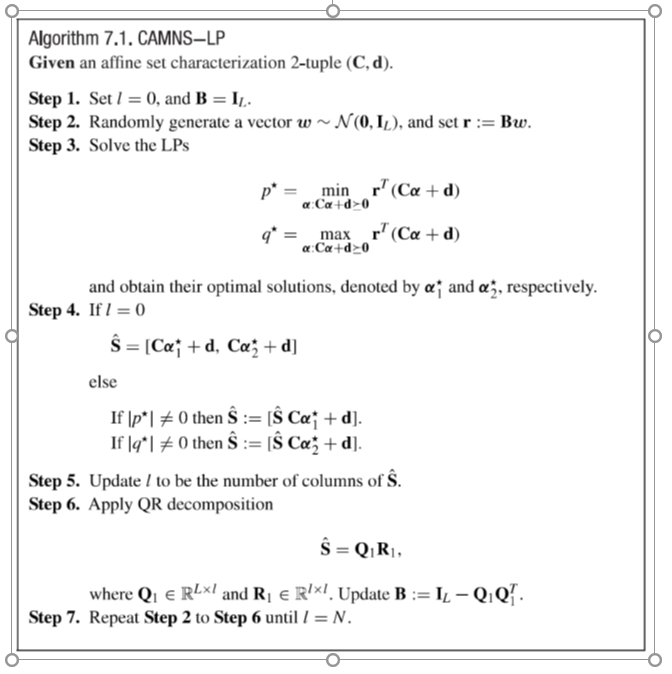

Реализуем метод строго в соответствии с полученными инструкциями

In [3]:
def camns_lp(C, d, L, N):
    # step 1:
    l = 0
    B = np.eye(L)
    
    while l != N:
        # step 2:
        w = sps.norm().rvs(L)
        r = (B @ w.reshape(-1, 1)).reshape(-1)

        # step 3:
        # solve LPs
        # p* = min r^T(C alpha + d) | c alpha + d >= 0 => alpha1*
        # q* = max r^T(C alpha + d) | c alpha + d >= 0 => alpha2*
        
        def optimized_func(alpha):
            nonlocal r, C, d
            result = r.dot(C @ alpha + d.reshape(-1))
            assert(np.isscalar(result))
            return result
        
        # optimize.LinearConstraint format: lb <= C.dot(alpha) <= ub
        constraint = LinearConstraint(C, lb=-d.reshape(-1), ub=np.ones(C.shape[0]) * np.inf)

        # find minimum
        alpha1 = minimize(optimized_func, x0=np.zeros(N-1), constraints=constraint).x
        # find maximum
        alpha2 = minimize(lambda x: -optimized_func(x), x0=np.zeros(N-1), constraints=constraint).x
        
        p_star = optimized_func(alpha1)
        q_star = optimized_func(alpha2)
        
        # step 4:
        column1 = ((C @ alpha1).reshape(-1) + d.reshape(-1)).reshape(-1, 1)
        column2 = ((C @ alpha2).reshape(-1) + d.reshape(-1)).reshape(-1, 1)
        if l == 0:
            S = np.hstack([column1, column2])
        else:
            if np.linalg.norm(p_star) > 0:
                S = np.hstack([S, column1])
            elif np.linalg.norm(q_star) > 0:
                S = np.hstack([S, column2])
            
        # step 5:
        l = S.shape[1]
        
        # step 6:
        Q, R = np.linalg.qr(S)
        B = np.eye(L) - Q @ Q.T
    return S

### Proposition 1 (для поиска $C$ и $d$)

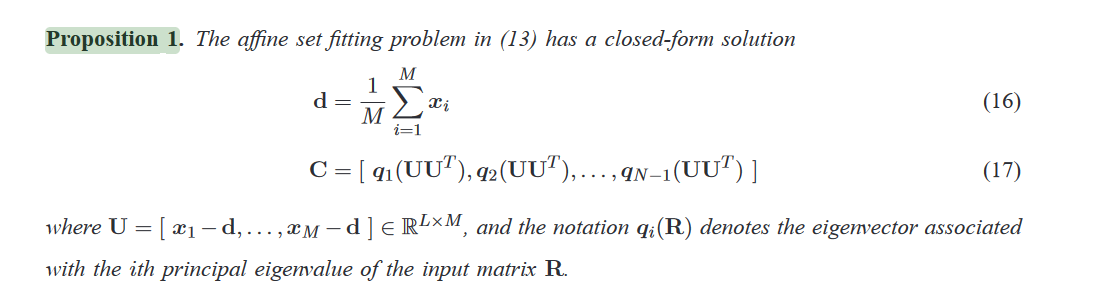

In [4]:
def get_d_C(X, N):
    # X в этом методе имеет размер F x M, M - число наблюдений, F - число фичей
    F, M = X.shape
    d = X.mean(axis=1).reshape(-1, 1)
    assert(d.shape == (F, 1))
    U = X - d
    C = U[:, 0:N-1]
    return d, C

**Протестируем наш метод**

In [5]:
def get_X(paths):
    images = []

    for path in paths:
        image = plt.imread(path)
        if len(image.shape) > 2:
            image = image[:,:,0]
        images.append(image)

    # для удобства визуализации используем только квадратные картинки
    assert(images[0].shape[0] == images[0].shape[1])
    for image in images:
        assert(image.shape == images[0].shape)
        
    X = np.array([image.reshape(-1) for image in images])
    return X

In [6]:
def test(S, mix_matrix):
    # S имеет размер N x F - число источников x число фичей
    # mix_matrix имеет размер M x N - число наблюдений x число фичей
    
    N, F = S.shape
    M, _ = mix_matrix.shape
    assert(mix_matrix.shape[1] == N)
    assert(M >= N)  # требуем, чтобы наблюдений было >= чем источников
    
    # тестируем на квадратных картинках (чтобы работала визуализация нормально)
    side = int(S.shape[1]**0.5)
    assert(side == S.shape[1] ** 0.5) 
           
    fig1, axes = plt.subplots(1, S.shape[0], figsize=(15, 6), sharey=True)
    fig1.suptitle('Исходные изображения', y=0.86)

    for ax, image in zip(axes, S):
        ax.grid(False)
        ax.imshow(image.reshape(side, side))
    
    # замешиваем картинки
    fig2, axes = plt.subplots(1, S.shape[0], figsize=(15, 6), sharey=True)
    fig2.suptitle('Перемешанные изображения', y=0.86)
    
    X = mix_matrix @ S
    for ax, mixed_image in zip(axes, X):
        ax.grid(False)
        ax.imshow(mixed_image.reshape(side, side))
    
    d, C = get_d_C(X.T, N)
    result = camns_lp(C, d, L=X.shape[1], N=3).T
    fig3, axes = plt.subplots(1, N, figsize=(15, 6), sharey=True)
    fig3.suptitle('Восстановленные изображения', y=0.86)
    for ax, result_image in zip(axes, result):
        ax.grid(False)
        ax.imshow(result_image.reshape(side, side))
    
    plt.show()

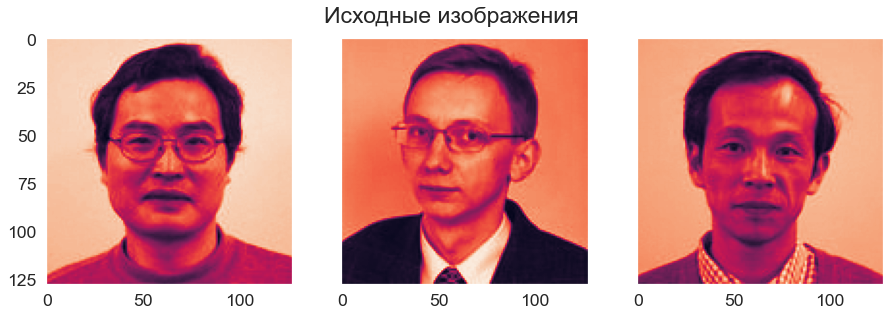

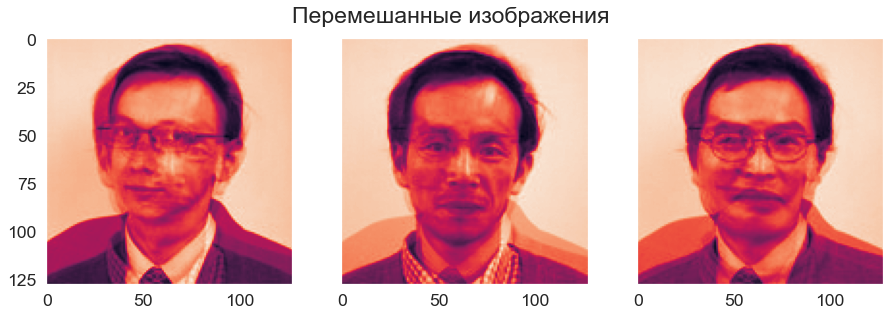

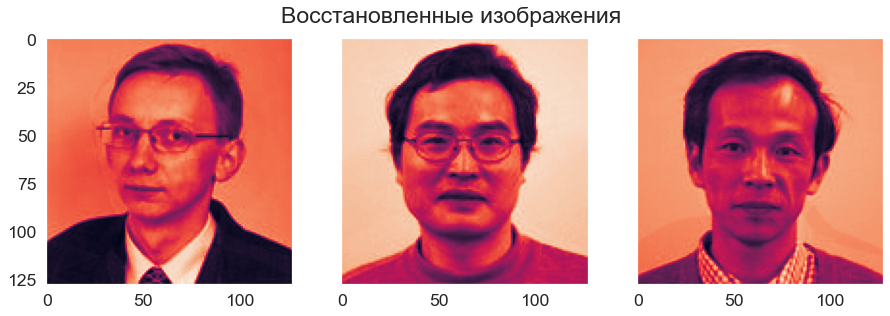

In [7]:
paths = [f'pictures/guy{i+1}.jpg' for i in range(3)]
X = get_X(paths)

mix_matrix = np.array([
    [0.2, 0.55, 0.3],
    [0.2, 0.15, 0.6],
    [0.6, 0.3, 0.1]
])

test(X, mix_matrix)

Как видим, наш метод восстановил изображения достаточно неплохо

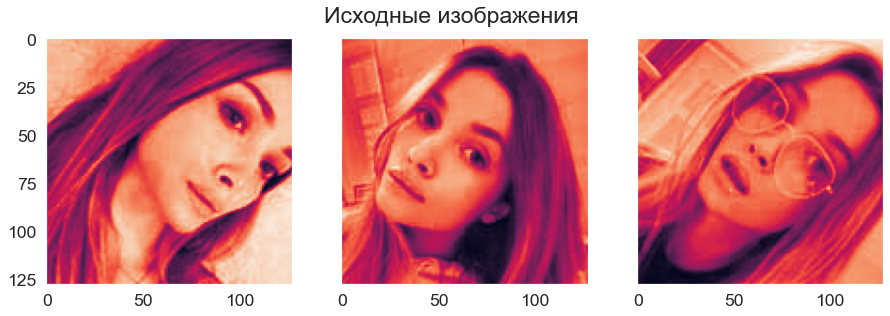

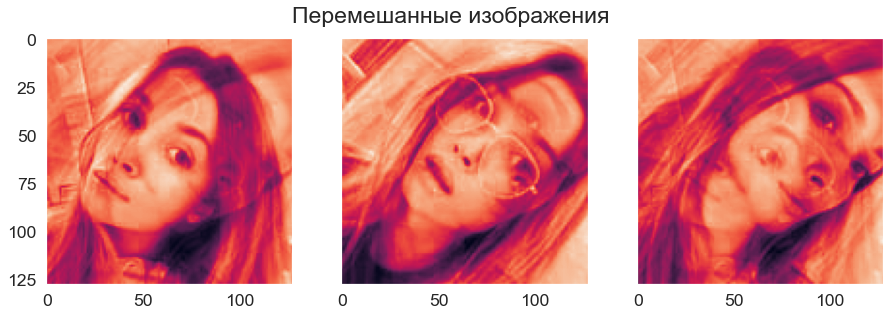

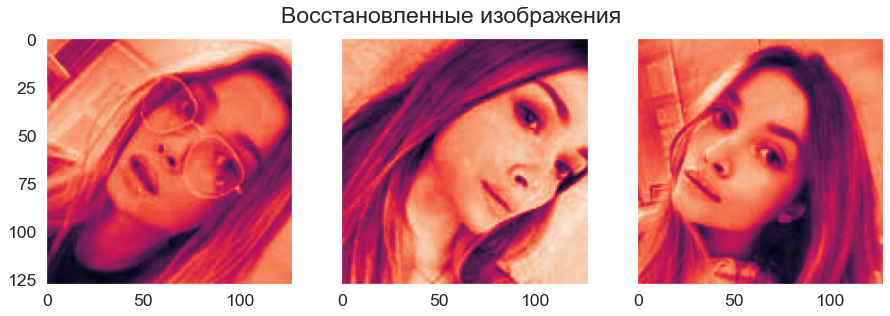

In [9]:
paths_girl = [f'pictures/girl{i+1}.jpg' for i in range(3)]
X_girl = get_X(paths_girl)

mix_matrix = np.array([
    [0.2, 0.6, 0.15],
    [0.2, 0.1, 0.6],
    [0.6, 0.3, 0.25]
])

test(X_girl, mix_matrix)

Как видим, наш метод восстановил изображения достаточно неплохо

In [14]:
def test_mixed(X, N):
    side = int(X.shape[1] **0.5)
    assert(X.shape[1] ** 0.5 == side)

    fig2, axes = plt.subplots(1, X.shape[0], figsize=(15, 6), sharey=True)
    fig2.suptitle('Перемешанные изображения', y=0.95)
    
    if X.shape[0] == 1:
        axes = [axes,]
    
    for ax, mixed_image in zip(axes, X):
        ax.grid(False)
        ax.imshow(mixed_image.reshape(side, side))
    
    d, C = get_d_C(X.T, N)
    result = camns_lp(C, d, L=X.shape[1], N=N).T
    fig3, axes = plt.subplots(1, N, figsize=(15, 6), sharey=True)
    fig3.suptitle('Восстановленные изображения', y=0.95)
    for ax, result_image in zip(axes, result):
        ax.grid(False)
        ax.imshow(result_image.reshape(side, side))
    plt.show()

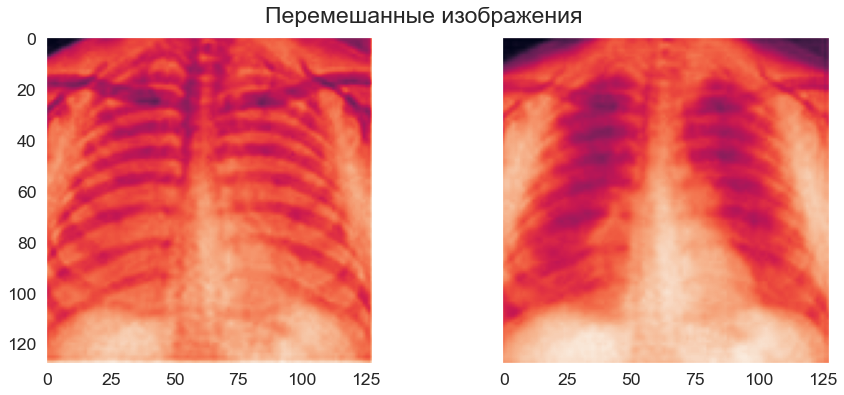

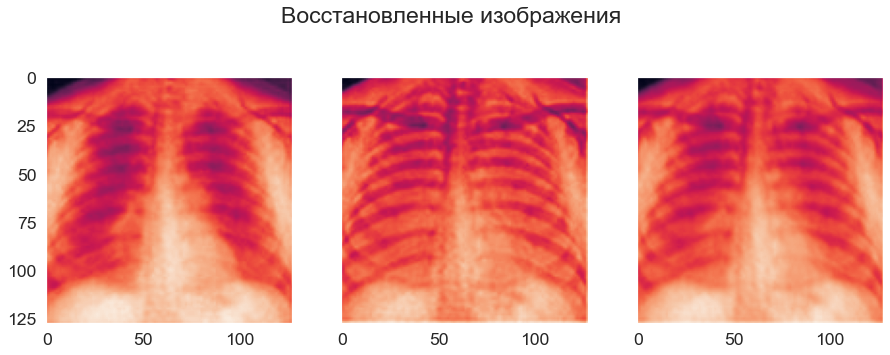

In [16]:
paths_xray = [f'pictures/xray{i+1}.jpg' for i in range(2)]
X_xray = get_X(paths_xray)
test_mixed(X_xray, 3)

Здесь никакого чуда не произошло и мы не увидели на восстановленных изображениях каждый орган человека по отдельности

**Вывод**:
- алгоритм сумел довольно хорошо восстановить исходные изображения по их линейным комбинациям в первых двух экспериментах
- в последнем случае с рентгеном все не очень хорошо, скорее всего, из-за качества картинок - наблюдений: они немного невыровнены друг с другом и даже не факт, что соответствуют одному и тому же человеку, я же эти картинки просто из презентации взял